In [2]:
import pandas as pd

In [ ]:
# THIS WAS ONLY USED TO GENERATE CSV FILES


'''file_path_weatherdata_2016 = "data/processed/Onsite-MetMast-SCADA-data-2016.xlsx"
file_path_weatherdata_2017 = "data/processed/Onsite-MetMast-SCADA-data-2017.xlsx"
file_path_turbinedata_2016 = "data/processed/Wind-Turbine-SCADA-signals-2016.xlsx"
file_path_turbinedata_2017 = "data/processed/Wind-Turbine-SCADA-signals-2017_0.xlsx"

wdf_2016 = pd.read_excel(file_path_weatherdata_2016)
wdf_2017 = pd.read_excel(file_path_weatherdata_2017)
tdf_2016 = pd.read_excel(file_path_turbinedata_2016)
tdf_2017 = pd.read_excel(file_path_turbinedata_2017)



wdf_2016.to_csv('data/processed/Onsite-MetMast-SCADA-data-2016.csv')
wdf_2017.to_csv('data/processed/Onsite-MetMast-SCADA-data-2017.csv')
tdf_2016.to_csv('data/processed/Wind-Turbine-SCADA-signals-2016.csv')
tdf_2017.to_csv('data/processed/Wind-Turbine-SCADA-signals-2017_0.csv')'''

In [ ]:
'''
wdf_2016.to_csv('data/processed/Onsite-MetMast-SCADA-data-2016.csv')
wdf_2017.to_csv('data/processed/Onsite-MetMast-SCADA-data-2017.csv')
tdf_2016.to_csv('data/processed/Wind-Turbine-SCADA-signals-2016.csv')
tdf_2017.to_csv('data/processed/Wind-Turbine-SCADA-signals-2017_0.csv')'''

In [ ]:
path = Path('../../..')
Path.BASE_PATH = path


In [3]:
wdf_2016 = pd.read_csv(path/'data/processed/Onsite-MetMast-SCADA-data-2016.csv', low_memory = False)
wdf_2017 = pd.read_csv(path/'data/processed/Onsite-MetMast-SCADA-data-2017.csv', low_memory=False)
tdf_2016 = pd.read_csv(path/'data/processed/Wind-Turbine-SCADA-signals-2016.csv',low_memory = False)
tdf_2017 = pd.read_csv(path/'data/processed/Wind-Turbine-SCADA-signals-2017_0.csv', low_memory=False)

Merge 2016 onsite with 2016 turbine data, and merge 2017 onsite with 2017 turbine data. Plan is to use 2016 as training and validation data, and 2017 as test data.

I think we should merge as outer join, not inner as we want to keep all data.

In [4]:
df_2016 = pd.merge(wdf_2016, tdf_2016, on='Timestamp', how='outer')
df_2017 = pd.merge(wdf_2017, tdf_2017, on='Timestamp', how='outer')


In [ ]:
pd.options.display.max_columns = None
df_2016.columns.tolist()

In [ ]:
wdf_2016.shape, tdf_2016.shape

### We have to be careful as the turbine dataset is much larger than the MET data. When combining these, we don't want to 1) lose data and 2) bias the model

In [ ]:
df_2016.shape

## Now we want to extract data from only Turbine 7

In [5]:
# Using pandas boolean indexing to create new dataframe where Turbine ID = T07
df_2016_T07 = df_2016[df_2016['Turbine_ID']=='T07'].copy().reset_index(drop=True)
df_2017_T07 = df_2017[df_2017['Turbine_ID']=='T07'].copy().reset_index(drop=True)

df_2016_T07.shape


(52445, 125)

That made the data we're working with 4x less

In [6]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
 
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8



In [ ]:
creds = '{"username":"magnusnordeide","key":"c4f77aea4277d9d887723d3e3749e8a1"}'

In [ ]:
cred_path = Path('./.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

### I don't think there are any ordinal data here, everything except timestamp is interval data.

In [ ]:
df_2016_T07['Max_Humidity'].unique()



In [ ]:
df_2016_T07['Gen_RPM_Avg']

## Let's plot the data to take a look at how it acts

In [7]:
import matplotlib.pyplot as plt

df_2016_T07['Timestamp'] = pd.to_datetime(df_2016_T07['Timestamp'])
df_2017_T07['Timestamp'] = pd.to_datetime(df_2017_T07['Timestamp'])

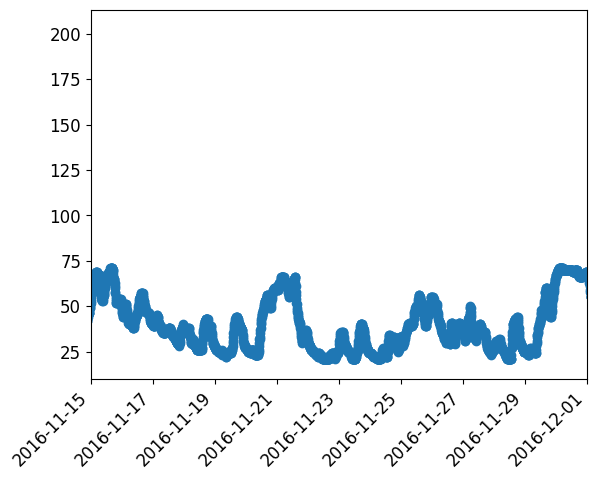

In [8]:


plt.scatter(df_2016_T07['Timestamp'],df_2016_T07['Gen_Bear_Temp_Avg'])
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))
plt.show()

In [ ]:
import seaborn as sns

#df_2016_T07 = df_2016_T07.sample(1000)
g = sns.pairplot(
    df_2016_T07, 
    x_vars=['Gen_Bear_Temp_Avg','Gen_RPM_Avg','Gen_Phase1_Temp_Avg','Nac_Temp_Avg','Avg_Windspeed1','Avg_Humidity'],
    y_vars=['Gen_Bear_Temp_Avg','Gen_RPM_Avg','Gen_Phase1_Temp_Avg','Nac_Temp_Avg','Avg_Windspeed1','Avg_Humidity']
              )

#to draw KDEs:
#g.map(sns.kdeplot, levels=4, color=".2")

### We see that the plot is similar to the one in Oliver's rapport. Only difference is there is no datacleaning done here, and Oliver also combined some of the columns into one (ex: avg_windspeed1, avg_windspeed2, avg_windspeed3 --> Wind_Speed in Olivers rapport)

### If we have ordinal values, we can inform pandas here


## Let's try to implement a decision tree, then a random forest before cleaning the data further..

# Implementing a decision tree

In [ ]:
# this is from fastai chapter 9
'''sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)'''

In [ ]:
dep_var = "Gen_Bear_Temp_Avg"

In [ ]:
# If we want to use RMSLE as metric:

# df_2016_T07[dep_var] = np.log(df_2016_T07[dep_var])
# df_2017_T07[dep_var] = np.log(df_2017_T07[dep_var])

### Handling dates

The first piece of data preparation we need to do is to enrich our representation of dates. The fundamental basis of the decision tree that we just described is *bisection*— dividing a group into two. We look at the ordinal variables and divide up the dataset based on whether the variable's value is greater (or lower) than a threshold, and we look at the categorical variables and divide up the dataset based on whether the variable's level is a particular level. So this algorithm has a way of dividing up the dataset based on both ordinal and categorical data.

But how does this apply to a common data type, the date? You might want to treat a date as an ordinal value, because it is meaningful to say that one date is greater than another. However, dates are a bit different from most ordinal values in that some dates are qualitatively different from others in a way that that is often relevant to the systems we are modeling.

In order to help our algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another. We might want our model to make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth. To do this, we replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful. 

PS. This may not be so useful for this implementation, but okay to test anyways!

fastai comes with a function that will do this for us—we just have to pass a column name that contains dates:

In [ ]:
df_2016_T07, df_2017_T07 = add_datepart(df_2016_T07, 'Timestamp'), add_datepart(df_2017_T07, 'Timestamp')

In [ ]:
# show new columns added:
' '.join(o for o in df_2016_T07.columns if o.startswith('Time'))

### Let's add TabularPandas and TabularProc

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [ ]:
procs = [Categorify, FillMissing]
procs

TabularPandas will also handle splitting the dataset into training and validation sets for us. 

Recall the distinction between a validation set and a test set, as discussed in <<chapter_intro>>. A validation set is data we hold back from training in order to ensure that the training process does not overfit on the training data. A test set is data that is held back even more deeply, from us ourselves, in order to ensure that *we* don't overfit on the validation data, as we explore various model architectures and hyperparameters.

We want to define our validation data so that it has the same sort of relationship to the training data as the test set will have.

In some cases, just randomly choosing a subset of your data points will do that. This is not one of those cases, because it is a time series.





In [ ]:
df_2016_T07.columns, df_2017_T07.columns

In [ ]:
# I think the dataset is already sorted based on timestamp, TODO: maybe check out later
#df_2016_T07 = df_2016_T07.sort_values('Timestamp')

# split 2016 set into training set and validation set
training_percentage = 0.66 # split is 33% training data, 17% validation data and 50% test data like in Olivers rapport. 66% training here because we only use 2016 dataset for test/validation
split_index = int(len(df_2016_T07) * training_percentage)

# split dataframe
train = df_2016_T07.iloc[:split_index].index
validation = df_2016_T07.iloc[split_index:].index

splits = (list(train), list(validation))


# To calculate percentages

total_data = len(df_2016_T07) + len(df_2017_T07)
train_percent = len(train) / total_data * 100
valid_percent = len(validation) / total_data * 100
test_percent = len(df_2017_T07) / total_data * 100

print(f"Training set: {round(train_percent,2)}%")
print(f"Validation set: {round(valid_percent,2)}%")
print(f"Test set: {round(test_percent,2)}%")

`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

In [ ]:
cont,cat = cont_cat_split(df_2016_T07,1,dep_var=dep_var)

In [ ]:
to = TabularPandas(df_2016_T07, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train),len(to.valid)

In [ ]:
to.show(3)

In [ ]:
to.items.head(3)

In [ ]:
#TODO: add path

save_pickle('models/to.pkl',to)

In [ ]:
# load model

to = load_pickle('models/to.pkl')
to

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y)

In [ ]:
draw_tree(m,xs,size=10,leaves_parallel=True, precision=2)

In [ ]:
import dtreeviz
samp_idx = np.random.permutation(len(y))[:500]
dtre_plot = dtreeviz.model(m, xs.iloc[samp_idx], y.iloc[samp_idx], feature_names = xs.columns, target_name=dep_var)
dtre_plot.view()

In [ ]:
m = DecisionTreeRegressor()
m.fit(xs,y);

We'll create a little function to check the root mean squared error of our model (`m_rmse`), since that's how the competition was judged (Oliver used root mean square error?)

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()),6)
def m_rmse(m,xs,y): return r_mse(m.predict(xs),y)

In [ ]:
m_rmse(m,xs,y)

So, our model is perfect, right? Not so fast... remember we really need to check the validation set, to ensure we're not overfitting:

In [ ]:
print(f'root mean square error: {m_rmse(m,valid_xs,valid_y)}')

In [ ]:
m.get_n_leaves(), len(xs)

We are overfitting badly as there are almost as many leaf nodes as data points!

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf = 25)
m.fit(to.train.xs, to.train.y)
print(f'root mean square error - training data: {m_rmse(m,xs,y)}, validation data: {m_rmse(m, valid_xs, valid_y)}')

In [ ]:
m.get_n_leaves(), len(xs)

# Implementing a random forest

We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

In the following function definition `n_estimators` defines the number of trees we want, `max_samples` defines how many rows to sample for training each tree, and `max_features` defines how many columns to sample at each split point (where `0.5` means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same `min_samples_leaf` parameter we used in the last section. Finally, we pass `n_jobs=-1` to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [ ]:
def rf(xs, y, n_estimators=60,
        max_features = 0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=1, n_estimators=n_estimators,
         max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs,y)

In [ ]:
m = rf(xs,y);

In [ ]:
print(f'root mean square error for - training set: {m_rmse(m,xs,y)}, and validation set: {m_rmse(m,valid_xs,valid_y)}')

Random forests aren't very sensitive to hyperparameter choices, such as max_features. n_estimators can be set as high as you have the time to train. max_samples can often be set to default, unless you have over 200,000 datapoints, in which case setting it to 200,000 will make it train faster with little impact on accuracy. 

### Out-of-bag error:


In [ ]:
print(f'out-of-bag error: {r_mse(m.oob_prediction_,y)}')

### Model interpretation:

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

Now we have a prediction for every tree and every temperature (60 trees and 17,832 temps(?) in the validation set.

Using this we can get the standard deviation of the predictions over all the trees, for each temperature:

In [ ]:
preds_std = preds.std(0)

Here are the standard deviations for the predictions for the first five temperatures—that is, the first five rows of the validation set:

In [ ]:
print(f'standard deviations for the first five rows of validation set: {preds_std[:5]}')

### Feature Importance

In [ ]:
def rf_feat_importance(m,df_2016_T07):
    return pd.DataFrame({'cols':df_2016_T07.columns, 'imp':m.feature_importances_}
                        ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest. We can see that the temperature in the generator phase has the highest impact on model predicitons.

In [ ]:
fi = rf_feat_importance(m,xs)
fi[:10]

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

I motsetning til Olivers rapport så har windspeed og nacelle temp lite å si i prediction her. 

### Removing Low-Importance Variables

In [ ]:
to_keep = fi[fi.imp>0.002].cols
len(to_keep)

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y)

In [ ]:
print(f'root mean square error for - test set: {m_rmse(m,xs_imp,y)}, and validation set: {m_rmse(m,valid_xs_imp,valid_y)}')

This removed A LOT of columns which lead to an increase in RMSE in training set by ONLY 0.2 and for validation set 0.1.
The process cut A LOT of time down on model training (from 1 minute 10 seconds to 4 seconds). It also lead to an increase of 0.2 in OOB error.


In [ ]:
print(f'out-of-bag error: {r_mse(m.oob_prediction_,y)}')

In [ ]:
print(f'num col. before: {len(xs.columns)}, after: {len(xs_imp.columns)}')

In [ ]:
plot_fi(rf_feat_importance(m,xs_imp));

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, `Gen_Phase2_Temp_Avg` and `Gen_Phase3_Temp_Avg`. Let's try to remove any redundent features.

### Removing Redundant Features

In [ ]:
cluster_columns(xs_imp)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left.

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. (In statistics it's called *R^2*, although the details aren't important for this explanation.) We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

In [ ]:
def get_oob(df_2016_T07):
    m = RandomForestRegressor(n_estimators=60, min_samples_leaf=15,
        max_features=0.5, n_jobs=1, oob_score=True)
    m.fit(df_2016_T07,y)
    return m.oob_score_

In [ ]:
get_oob(xs_imp)

This function iteratively removes one feature from the model, and calculates the OOB-score. The purpose is to see how much the OOB-score changes for each redundant feature removed

In [ ]:
{c:get_oob(xs_imp.drop(c,axis=1)) for c in (
    'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Cont_Top_Temp_Avg','Cont_VCP_Temp_Avg'
)}

Let's try to drop one from each of the tightly pairs we noticed earlier in the chart.

In [ ]:
to_drop = ['Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg','Gear_Bear_Temp_Avg','Cont_VCP_Temp_Avg']
get_oob(xs_imp.drop(to_drop,axis=1))

Looking good! R^2 barely changed, lets create DataFrames without these columns, and save them:

In [ ]:
xs_final = xs_imp.drop(to_drop,axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [ ]:
save_pickle('models/xs_final.pkl', xs_final)
save_pickle('models/valid_xs_final.pkl', valid_xs_final)

We can load them back later with:

In [ ]:
xs_final = load_pickle('models/xs_final.pkl')
valid_xs_final = load_pickle('models/valid_xs_final.pkl')

In [ ]:
m = rf(xs_final, y)
print(f'root mean square error for - test set: {m_rmse(m,xs_final,y)}, and validation set: {m_rmse(m,valid_xs_final,valid_y)}')

In [ ]:
m

In [ ]:
plot_fi(rf_feat_importance(m,xs_final));

In [ ]:
cluster_columns(xs_final)

### Partial Dependence

The most important features are Gen_Phase_Temp_Avg and Cont_VCP_ChokcoilTemp_Avg. We'd like to understand the relationship between these predictors and bearing temperature. 

In [ ]:
p = valid_xs_final['Gen_Phase1_Temp_Avg'].plot.hist()
plt.xlabel('Gen_Phase1_Temp_Avg')
plt.show()

In [ ]:
p = valid_xs_final['Cont_VCP_ChokcoilTemp_Avg'].plot.hist()
plt.xlabel('Cont_VCP_ChokcoilTemp_Avg')
plt.show()

Now we're ready to look at *partial dependence plots*. Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?

For instance, how does `Cont_VCP_ChokcoilTemp_Avg` impact bearing temp, all other things being equal?

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12,4))
PartialDependenceDisplay.from_estimator(m,valid_xs_final, ['Cont_VCP_ChokcoilTemp_Avg', 'Gen_Phase1_Temp_Avg'],
                                        grid_resolution=20, ax=ax);


### Tree Interpreter

In [ ]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

Now we want to answer: For prediciting with a particular row of data, what were the most important factors, and how did they influence that prediction?

In [ ]:
row = valid_xs_final.iloc[:5]

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [ ]:
prediction[0], bias[0], contributions[0].sum()

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
          rotation_value=45, formatting='{:,.3f}');

### Out-of-domain data

In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m,df_dom[:6])

This shows that there are three columns that differ significantly between the training and validation sets: 'HVTrafo_Phase3_Temp_Avg','HVTrafo_Phase2_Temp_Avg',and 'Cont_VCP_ChokcoilTemp_Avg'

In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('HVTrafo_Phase3_Temp_Avg','HVTrafo_Phase2_Temp_Avg','Cont_VCP_ChokcoilTemp_Avg'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

In [ ]:
time_vars = ['HVTrafo_Phase3_Temp_Avg']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

Removing this variable has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand.

In addition we could try training on a subset of the data, which might improve the models accuracy once more. See lecture 9 fastai